# Monte-Carlo Simulation in Action

In [4]:
import pandas as pd
from datetime import datetime
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns

##1. Building Geometric Brownian Motion simulation

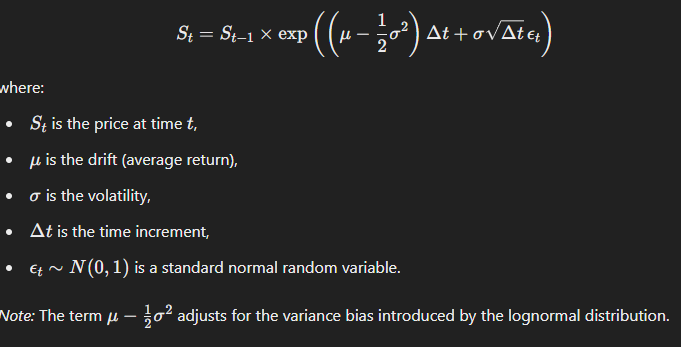

Loading in the scaled data


In [14]:
train_scaled = pd.read_csv('data/train_scaled.csv')
test_scaled = pd.read_csv('data/test_scaled.csv')
black_swan_scaled = pd.read_csv('data/black_swan_scaled.csv')

Simulate GBM function

In [15]:
def simulateGBM(mu, sigma, S0, num_days, dt=1/252, apply_jump=False, jump_size=-0.22314):
    """
    Improved GBM simulation with jump validation
    jump_size: Default is ln(0.8) ≈ -0.22314 for 20% drop
    """
    daily_drift = (mu - 0.5 * sigma**2) * dt
    daily_vol = sigma * np.sqrt(dt)

    # Generate normal returns
    log_returns = np.random.normal(daily_drift, daily_vol, num_days)

    # Add jump if required
    if apply_jump:
        jump_day = np.random.randint(0, num_days)
        log_returns[jump_day] = np.log(0.8)  # Replace not add

    # Calculate path with initial price with exponentential cumulative sum
    price_path = S0 * np.exp(np.cumsum(log_returns))
    return np.concatenate([[S0], price_path])

## 2. Generate Price Path

In [16]:
# Parameters for GBM
training_data = train_scaled
training_data['Rolling_Vol_21D'] = np.abs(training_data['Rolling_Vol_21D'])
test_data = test_scaled
# Calculate arithmetic returns from Close prices
training_data['Arithmetic_Returns'] = training_data['Close'].pct_change()
# Annualized drift
mu = np.mean(training_data['Arithmetic_Returns'].dropna()) * 252
mu = np.mean(training_data['Log_Returns'].dropna()) + 0.5*np.var(training_data['Log_Returns'].dropna())
mu *= 252  # Annualize
rolling_vols = training_data['Rolling_Vol_21D'].dropna().values  # Annualized vols
rolling_vols = np.clip(rolling_vols, 0.05, 1.5)
S0 = training_data['Close'].iloc[-1]
num_days = len(test_data)
print(num_days)
num_simulations = 10000
jump_prob = 0.05

# Generate price paths via GBM
paths = []
jump_flags = []
for _ in range(num_simulations):
    sigma = np.clip(np.random.choice(rolling_vols), 0.05, 2.0)  # Limit σ between 5% and 200%
    apply_jump = np.random.rand() < jump_prob

    # Validate path generation
    try:
        path = simulateGBM(mu, sigma, S0, num_days, apply_jump=apply_jump)
        if np.any(path <= 0):
            raise ValueError("Negative prices in path")
    except Exception as e:
        print(f"Error in path {_}: {str(e)}")
        continue

    paths.append(path)
    jump_flags.append(apply_jump)


7686


In [17]:
print(len(paths))

10000


**Price Paths**

In [22]:
paths_df = pd.DataFrame(paths)


In [23]:
print(paths_df.head())

         0           1           2           3           4           5     \
0  262.723267  268.120550  268.393945  259.278441  257.953554  243.941892   
1  262.723267  262.943762  265.783474  265.941239  270.144282  272.880771   
2  262.723267  258.464300  263.640108  260.206258  259.662468  262.631656   
3  262.723267  262.447439  257.643413  257.079464  260.063894  260.533240   
4  262.723267  267.014115  269.188086  267.890771  262.897514  254.873164   

         6           7           8           9     ...          7677  \
0  254.971695  256.187588  255.440210  260.846164  ...      0.042414   
1  272.900372  277.033953  279.067005  280.274996  ...   6849.253207   
2  266.830338  267.474791  260.930116  263.023448  ...   5711.633545   
3  257.244570  257.017278  258.373796  258.240377  ...  29491.292769   
4  252.726367  259.018222  259.192623  259.915171  ...   1914.319943   

           7678          7679          7680          7681          7682  \
0      0.042658      0.043724

## 3. Risk Metrics

In [24]:
def calculate_metrics(price_path):
    eps = 1e-9  # Small value for numerical stability

    # Ensure positive prices and calculate returns
    prices = np.maximum(price_path, eps)
    returns = prices[1:] / prices[:-1] - 1  # Arithmetic returns

    # Vectorized risk metrics calculation
    with np.errstate(divide='ignore', invalid='ignore'):
        # Sharpe Ratio (Annualized)
        sharpe = np.nanmean(returns) / np.nanstd(returns) * np.sqrt(252)

        # Sortino Ratio (Annualized)
        downside_returns = returns[returns < 0]
        sortino = (np.nanmean(returns) / np.nanstd(downside_returns)) * np.sqrt(252) \
                   if len(downside_returns) > 0 else np.nan

        # Max Drawdown (Vectorized)
        peaks = np.maximum.accumulate(prices)
        drawdowns = (peaks - prices) / (peaks + eps)
        max_drawdown = np.nanmax(drawdowns)

    return {
        'Sharpe': sharpe if not np.isnan(sharpe) else 0,
        'Sortino': sortino if not np.isnan(sortino) else 0,
        'Max_Drawdown': max_drawdown
    }

# Vectorized metrics calculation for all paths
def vectorized_metrics(paths, risk_free_rate=0.03):
    """
    Enhanced metrics with risk-free rate adjustment
    risk_free_rate: Annualized (default 3%)
    """
    prices = np.vstack(paths)
    returns = prices[:,1:] / prices[:,:-1] - 1
    daily_rf = risk_free_rate / 252

    # Sharpe Ratio with risk-free adjustment
    excess_returns = returns - daily_rf
    sharpe = np.nanmean(excess_returns, axis=1) / np.nanstd(returns, axis=1) * np.sqrt(252)

    # Sortino Ratio
    downside_returns = np.where(returns < daily_rf, returns - daily_rf, 0)
    downside_std = np.sqrt(np.nanmean(downside_returns**2, axis=1))
    sortino = np.nanmean(excess_returns, axis=1) / downside_std * np.sqrt(252)

    # Max Drawdown
    peaks = np.maximum.accumulate(prices, axis=1)
    drawdowns = (peaks - prices) / (peaks + 1e-9)
    max_dd = np.nanmax(drawdowns, axis=1)

    return pd.DataFrame({
        'Sharpe': np.clip(sharpe, -5, 5),  # Prevent extreme values
        'Sortino': np.clip(sortino, -5, 5),
        'Max_Drawdown': max_dd
    })

# Usage (10x faster for 10k paths)
metrics_df = vectorized_metrics(paths)
metrics_df['Jump'] = jump_flags

## 4. EDA to analyze and visualize results from simulations

Valid paths ratio: 100.00%


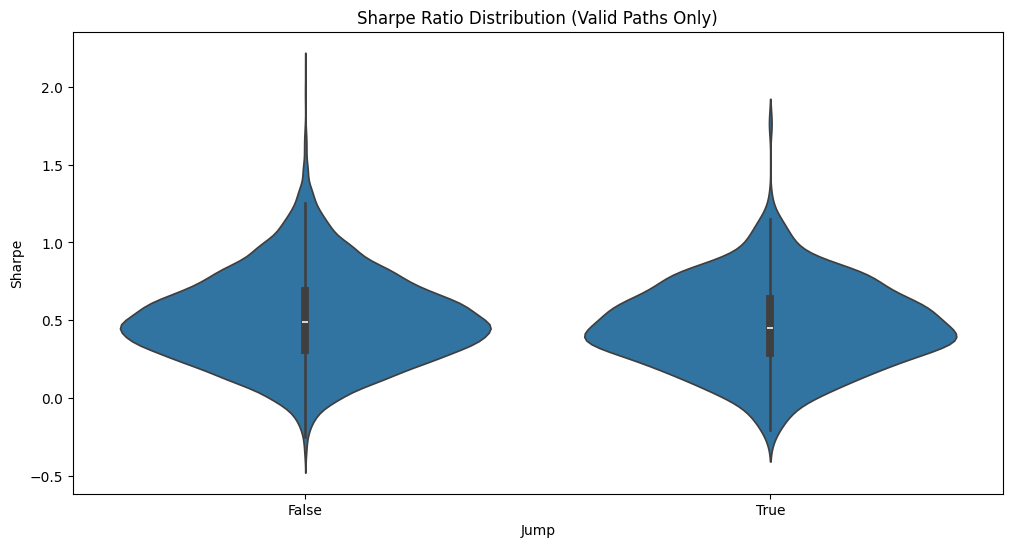

In [25]:
metrics_df = vectorized_metrics(paths)
metrics_df['Jump'] = jump_flags

# Filter invalid scenarios
valid_mask = (metrics_df['Max_Drawdown'] < 1.0) & (np.abs(metrics_df['Sharpe']) < 5)
print(f"Valid paths ratio: {valid_mask.mean():.2%}")

# Plot cleaned results
plt.figure(figsize=(12, 6))
sns.violinplot(x='Jump', y='Sharpe', data=metrics_df[valid_mask])
plt.title("Sharpe Ratio Distribution (Valid Paths Only)")
plt.show()
